# GTDB

## Background

[GTDB](http://gtdb.ecogenomic.org/) (Genome Taxonomy Database) is a large-scale effort of curating microbial taxonomy based on phylogeny. The dataset includes NCBI RefSeq (GCF) and GenBank (GCA) genomes, as well as genomes they assembled from publicly available metagenomes (UBA). The current release - r80 - contains 94,759 bacterial genomes and 1,741 archaeal genomes. The data for the bacterial genomes are available at the [website](http://gtdb.ecogenomic.org/downloads).

## Preparation

### Dependencies

In [45]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from skbio import TreeNode, DistanceMatrix

### Raw data

Three files are relevant to this study:

Metadata: `bac_metadata_r80.tsv`

In [2]:
!bzcat raw/bac_metadata_r80.tsv.bz2 | cut -f1-5 | head -n5

accession	scaffold_count	gc_count	longest_scaffold	gc_percentage
GB_GCA_000006155.2	3	1869446	5093554	35.1014036461
GB_GCA_000006945.2	2	2586547	4857450	52.2388795211
GB_GCA_000007765.2	2	865989	1995488	42.6006502339
GB_GCA_000010565.1	1	1602272	3025375	52.9611039954


Taxonomy: `bac_taxonomy_r80.tsv`

In [7]:
!bzcat raw/bac_taxonomy_r80.tsv.bz2 | cut -c1-100 | head -n5

UBA11131	d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae
GB_GCA_001941065.1	d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__
RS_GCF_001404535.1	d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__B
RS_GCF_900055025.1	d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__St
RS_GCF_001476715.1	d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enter


Tree: `bac120_r80.tree`, which contains

In [9]:
!cat raw/bac120_r80.tree | cut -c1-500

((GB_GCA_001778455.1:0.39861,((GB_GCA_002375995.1:0.18979,(((UBA7962:0.01111,UBA7968:0.00451)'100.0:s__UBA2187 sp2':0.09573,((GB_GCA_002403185.1:0.00055,GB_GCA_002328705.1:0.0008)'100.0:s__UBA2187 sp1':0.07637,(GB_GCA_002402715.1:0.01307,GB_GCA_002479455.1:0.01374)'100.0:s__UBA2187 sp3':0.07693)99.0:0.03278)'100.0:g__UBA2187':0.17404,((UBA12530:0.0,GB_GCA_001508155.1:0.0)'100.0:s__64-32 sp1':0.10308,GB_GCA_002375935.1:0.10361)'100.0:g__64-32':0.06338)100.0:0.05701)'100.0:o__OPB14; f__64-32':0.16


## Analyses

#### Identify shared genomes

Read WoL genome IDs

In [3]:
wol_gs = !cat ../../genomes/gids.txt
len(wol_gs)

86200

Read GTDB genome IDs.

In [4]:
gtdb_gs = !bzcat raw/bac_metadata_r80.tsv.bz2 | cut -f1 | tail -n+2
len(gtdb_gs)

94759

Generate a GTDB to WoL genome ID map. e.g., `GB_GCA_000006155.2` => `GC000006155`.

In [153]:
gtdb2wol_map = {x: 'G%s' % x.split('_')[-1].split('.')[0] for x in gtdb_gs if x.startswith('GB_GCA_') or x.startswith('RS_GCF_')}
len(gtdb2wol_map)

91672

Check for duplicate genomes in GTDB (same assembly ID represented by both RefSeq and GenBank versions).

In [191]:
gtdb_dups = set()
used = set()
for gtdb, wol in gtdb2wol_map.items():
    if wol in used:
        gtdb_dups.add(wol)
    else:
        used.add(wol)
len(gtdb_dups)

25

Identify shared genome IDs.

In [6]:
common_gs = set(wol_gs).intersection(set(gtdb2wol_map.values()))
len(common_gs)

79364

#### Shrink trees to shared taxa

In [7]:
wol_tree = TreeNode.read('../../ToLs/astral.MR.rooted.nid.tre')
wol_tree.count(tips=True)

10575

In [8]:
gtdb_tree = TreeNode.read('raw/bac120_r80.tree', convert_underscores=False)
gtdb_tree.count(tips=True)

21943

Identify taxa shared between the two trees.

In [9]:
wol_taxa = set([tip.name for tip in wol_tree.tips()])
gtdb_taxa = set([tip.name for tip in gtdb_tree.tips()])
common_taxa = [(x, gtdb2wol_map[x]) for x in gtdb_taxa if x in gtdb2wol_map
               and gtdb2wol_map[x] in wol_taxa]
len(common_taxa)

7556

Shrink the two trees to contain common taxa only.

In [10]:
wol_tree_lap = wol_tree.shear([x[1] for x in common_taxa])
wol_tree_lap.write('wol.lap.nwk')

'wol.lap.nwk'

In [11]:
gtdb_tree_lap = gtdb_tree.shear([x[0] for x in common_taxa])

The GTDB tree have additional node labels that do not comply with the Newick standard. To avoid problems, remove node labels.

In [12]:
_tree = gtdb_tree_lap.copy()
for node in _tree.non_tips():
    node.name = None
_tree.write('gtdb.lap.nwk')

'gtdb.lap.nwk'

Translate GTDB genomes IDs into WoL ones in the shrinked GTDB tree.

In [13]:
gtdb_tree_lap_tr = gtdb_tree_lap.copy()
for tip in gtdb_tree_lap_tr.tips():
    tip.name = gtdb2wol_map[tip.name]

In [14]:
_tree = gtdb_tree_lap_tr.copy()
for node in _tree.non_tips():
    node.name = None
_tree.write('gtdb.lap.tr.nwk')

'gtdb.lap.tr.nwk'

### Compare GTDB and WoL trees

#### Preparation

WoL tree with node supports:

In [56]:
tree1 = TreeNode.read('../../ToLs/astral.MR.rooted.tre')
tree1 = tree1.shear([x[1] for x in common_taxa])

Because duplicated sequences were assigned as polytomies without branch length, set them as zeros.

In [57]:
for node in tree1.traverse():
    if node.length is None:
        node.length = 0.0

GTDB tree with node supports:

In [58]:
tree2 = gtdb_tree_lap_tr.copy()

Delete extra node labels, leaving only node support values.

In [59]:
for node in tree2.non_tips():
    if node.name is not None:
        node.name = node.name.split(':')[0]

#### Basic statistics

Robinson-Foulds distance between the two trees:

In [38]:
tree1.compare_rfd(tree2, proportion=True)

0.17919841006955944

Maximum distance between tips:

In [39]:
tree1.get_max_distance()[0]

53.626845927682865

In [40]:
tree2.get_max_distance()[0]

3.86313

Average node support values:

In [41]:
def average_support(tree):
    supports = []
    for node in tree.non_tips():
        if node.name is not None:
            supports.append(float(node.name))
    return sum(supports) / float(len(supports))

In [42]:
average_support(tree1)

0.9483053091486772

In [43]:
average_support(tree2)

89.48438953102166

#### Functions to collapse trees

In [25]:
def collapse(node):
    """Collapse an internal node of a tree."""
    length = node.length
    parent = node.parent
    for child in node.children:
        if child.length is None:
            print(child.name)
        child.length += length
    parent.remove(node)
    parent.extend(node.children)

In [26]:
def collapse_short_branches(tree, cutoff):
    """Collapse branches with length below cutoff."""
    res = tree.copy()
    while True:
        nodes_to_collapse = []
        for node in res.non_tips():
            if node.length < cutoff:
                nodes_to_collapse.append(node)
        if len(nodes_to_collapse) == 0:
            break
        for node in nodes_to_collapse:
            collapse(node)
    return res

In [50]:
def collapse_low_support_nodes(tree, cutoff):
    """Collapse internal nodes with support value below cutoff."""
    res = tree.copy()
    nodes_to_collapse = []
    for node in res.non_tips():
        if node.name is not None:
            support = float(node.name.split(':')[0])
            if support < cutoff:
                nodes_to_collapse.append(node)
    for node in nodes_to_collapse:
        collapse(node)
    return res

Function to shrink two trees to contain only shared taxa.

In [54]:
def intersect_trees(tree1, tree2, mapping=None):

    taxa1 = set([tip.name for tip in tree1.tips()])
    taxa2 = set([tip.name for tip in tree2.tips()])

    if mapping is not None:
        if len(set(mapping.values())) < len(mapping.keys()):
            raise ValueError('Mapping is not strict one-to-one match.')

        common_taxa_map = [(x, mapping[x]) for x in taxa1 if x in mapping and mapping[x] in taxa2]

        if len(common_taxa_map) == 0:
            raise ValueError('Trees have no overlapping taxa.')

        tree1_lap = tree1.shear([x[0] for x in common_taxa])
        tree2_lap = tree2.shear([x[1] for x in common_taxa])

    else:
        common_taxa = taxa1.intersection(taxa2)
        if len(common_taxa_map) == 0:
            raise ValueError('Trees have no overlapping taxa.')

        tree1_lap = tree1.shear(common_taxa)
        tree2_lap = tree2.shear(common_taxa)

    return (tree1_lap, tree2_lap)

#### Plotting

Compute RF distances between trees with low-support nodes collapsed.

In [72]:
data = []
for i in (0.99, 0.95, 0.9, 0.8, 0.7, 0.5, 0.1):
    _tree1 = collapse_low_support_nodes(tree1, i)
    for j in (99, 95, 90, 80, 70, 50, 10):
        _tree2 = collapse_low_support_nodes(tree2, j)
        data.append([i, j, _tree1.compare_rfd(_tree2, proportion=True)])

In [81]:
columns=['wol', 'gtdb', 'rf']
df = pd.DataFrame(data, columns=columns)
df.head()

,wol,gtdb,rf
0,0.99,99,0.167338
1,0.99,95,0.157984
2,0.99,90,0.154625
3,0.99,80,0.151270
4,0.99,70,0.151266


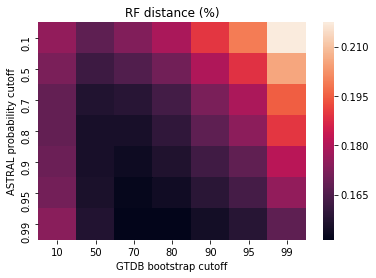

In [89]:
ax = sns.heatmap(df.pivot('wol', 'gtdb', 'rf'))
ax.set_title('RF distance (%)')
ax.set_xlabel('GTDB bootstrap cutoff')
ax.set_ylabel('ASTRAL probability cutoff');

Putative minimum RF:

In [88]:
collapse_low_support_nodes(tree1, 0.95).compare_rfd(collapse_low_support_nodes(tree2, 70), proportion=True)

0.15224806201550387

### Taxonomy

Load GTDB taxonomy

In [227]:
ranks = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [228]:
df = pd.read_table('gtdb_taxonomy.tsv.bz2', index_col=0, names=['genome'] + ranks)
df = df.loc[sorted(gtdb2wol_map)]
df['gid'] = df.index.to_series().map(gtdb2wol_map)

Make sure duplicated genome IDs have identical taxonomy annotations.

In [229]:
vc = df['gid'].value_counts()
dups = vc[vc > 1].index.tolist()

In [230]:
for dup in dups:
    rows = df[df.gid == dup]
    for rank in ranks:
        if len(set(rows[rank].tolist())) > 1:
            raise ValueError('%s has conflicting taxonomy annotations.' % dup)

Subset and translate the genome IDs.

In [231]:
df.set_index('gid', inplace=True)
defined_taxa = set(df.index.tolist()).intersection(wol_taxa)
len(defined_taxa)

8934

In [232]:
df = df.loc[sorted(defined_taxa)]
df = df[~df.index.duplicated(keep='first')]
df.head()

,domain,phylum,class,order,family,genus,species
gid,,,,,,,
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_D,Bacillus_S,Bacillus_S pseudofirmus
G000006605,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium jeikeium
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,Xylella fastidiosa
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio,Vibrio cholerae
G000006785,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus pyogenes


Function to compute cladistics

In [167]:
def compute_cladistics(tree, df):
    data = []
    ranks = list(df)
    for rank in ranks:
        used_taxa = set()
        for taxon in df[rank].unique():
            if taxon in used_taxa:
                raise ValueError('duplicated taxon name %s.' % taxon)
            used_taxa.add(taxon)
            # skip undefined taxa
            if pd.isnull(taxon):
                continue
            row = [taxon, rank]
            # find all tips that match this rank
            func = lambda x: x.is_tip() and df[rank][x.name] == taxon
            tips = [x for x in tree.find_by_func(func)]
            # single taxon
            if len(tips) == 1:
                row.extend([1, 1, tips[0].name, 'uni'])
            # multiple taxa
            else:
                # locate lowest common ancestor (LCA) of the tips
                lca = tree.lca(tips)
                members = len(tips)
                # count total number of descendants of the LCA
                descendants = len(lca.subset())
                # test whether this clade is a monophyletic group
                phyly = 'mono' if members == descendants else 'poly'
                row.extend([members, descendants, lca.name, phyly])
            data.append(row)
    columns = ['taxon', 'rank', 'members', 'descendants', 'lca', 'phyly']
    res = pd.DataFrame(data, columns=columns)
    res['rank'] = pd.Categorical(res['rank'], ranks)
    return res.sort_values(['rank', 'taxon'])

Compute cladistics for the WoL tree based on the GTDB taxonomy.

In [168]:
wol_tree_defined = wol_tree.shear(defined_taxa)

In [170]:
cladistics = compute_cladistics(wol_tree_defined, df)

In [173]:
cladistics.to_csv('cladistics.tsv', sep='\t')

In [186]:
phylies = {}
for rank in ranks:
    phylies[rank] = cladistics.query('rank == "%s"' % rank)['phyly'].value_counts().to_dict()

In [187]:
phylies = pd.DataFrame.from_dict(phylies, orient='index').fillna(0).astype(int)
phylies = phylies.loc[ranks]
phylies

,mono,uni,poly
domain,1,0,0
phylum,51,25,3
class,125,53,7
order,302,147,11
family,623,371,11
genus,1333,1992,13
species,715,4320,3


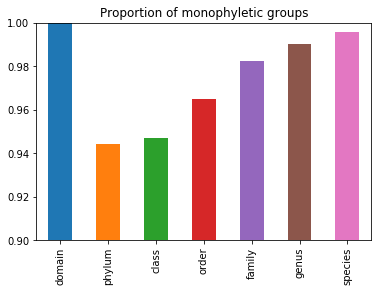

In [237]:
phylies['rate'] = phylies['mono'] / (phylies['mono'] + phylies['poly'])
phylies['rate'].plot.bar(ylim=(0.9, 1.0), title='Proportion of monophyletic groups');